In [1]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import celluloid
import sklearn.datasets as ds
plt.style.use("ggplot")
cmap = "Set1"
NEWAXIS = np.newaxis
np.random.seed(42)

In [2]:
X, y = ds.make_moons(16**2, 2, noise=0.2)
n_examples, n_features = X.shape
n_examples, n_features

(256, 2)

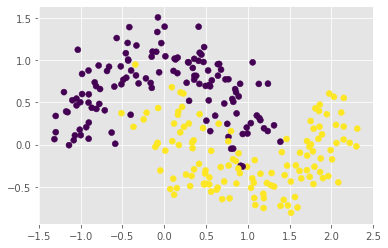

In [3]:
plt.scatter(X[:,0],X[:,1],c=y)

In [4]:
rez = int(n_examples**(0.5))
d0 = np.arange(X[:, 0].min(),
               X[:, 0].max(),
               (X[:, 0].max() - X[:, 0].min())/rez)
d1 = np.arange(X[:, 1].min(),
               X[:, 1].max(),
               (X[:, 1].max() - X[:, 1].min())/rez)
domain = np.transpose([np.tile(d0,   len(d0)),
                       np.repeat(d1, len(d1))])
d0, d1 = np.meshgrid(d0, d1)

In [ ]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-(Z)))
def sigmoid_forward(Z):
    return sigmoid(Z)
def sigmoid_backward(Z):
    return sigmoid(Z) * (1-sigmoid(Z))
    
def relu_forward(Z):
    Z[Z<0] = 0
    return Z
def relu_backward(Z):
    return 0<Z

def cost(y, y_pred):
    assert y.shape == y_pred.shape, (y.shape, y_pred.shape)
    return np.mean(-y*np.log(y_pred) - (1-y)*np.log(1-y_pred))
def cost_prime(y, y_pred):
    return y_pred - y

learning_rate = 1
n_iterations  = 1000
l0_hidden_units = 6
l1_hidden_units = 1

W0 = np.random.uniform(-0.1, 0.1, size=(n_features, l0_hidden_units))
b0 = np.zeros((1, l0_hidden_units))
W1 = np.random.uniform(-0.1, 0.1, size=(l0_hidden_units, l1_hidden_units))
b1 = np.zeros((1, l1_hidden_units))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
camera = celluloid.Camera(fig)
plt.tight_layout()

def forward_prop(X, W1, b1, W0, b0):
    # hidden layer 1
    Z0 = (X@W0)+b0
    A0 = relu_forward(Z0)
    assert A0.shape == Z0.shape == (n_examples, l0_hidden_units)
    # hidden layer 2
    Z1 = (A0@W1)+b1
    A1 = sigmoid_forward(Z1)
    assert A1.shape == Z1.shape == (n_examples, l1_hidden_units), (A1.shape, Z1.shape)
    
    return A0, A1, Z0, Z1

def calculate_gradients(A0, A1, Z0, Z1, W0, W1, b0, b1, Y):
    assert A1.shape == Y.shape
    # hidden layer 1
    dZ1 = (A1 - Y)
    assert dZ1.shape == Z1.shape
    dW1 = (A0.T@dZ1) / n_examples
    assert dW1.shape == W1.shape, (dW1.shape, W1.shape)
    db1 = np.mean(dZ1, axis=0, keepdims=True)
    assert db1.shape == b1.shape, (db1.shape, b1.shape)
    # hidden layer 0
    dZ0 = np.multiply(W1@dZ1.T, relu_backward(Z0).T).T
    assert dZ0.shape == Z0.shape
    dW0 = (dZ0.T@X) / n_examples
    dW0 = dW0.T # TODO: fix the shape here
    assert dW0.shape == W0.shape, (dW0.shape, W0.shape)
    db0 = np.mean(dZ0, axis=0, keepdims=True)
    assert db0.shape == b0.shape, (db0.shape, b0.shape)
    
    return dW0, dW1, db0, db1

losses = []
accuracies = []
for i in range(n_iterations):
    if i % 50:
        learning_rate * 0.7
    forward_prop_activations = forward_prop(X, W1, b1, W0, b0)
    dW0, dW1, db0, db1 = \
        calculate_gradients(*forward_prop_activations, W0, W1, b0, b1, y[:,NEWAXIS])
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W0 -= learning_rate * dW0
    b0 -= learning_rate * db0
    _, y_pred, _, _ = forward_prop_activations
    correct = (y == np.squeeze(0.5 < y_pred))
    
    losses.append((i, cost(y[:,NEWAXIS], y_pred).mean()))
    accuracies.append((i, correct.mean()))
    
    if i % 25 == 0:
        _, d_pred, _, _ = forward_prop(domain, W1, b1, W0, b0)
        contour = ax1.contourf(d0, d1, d_pred.reshape(rez,rez))

        ax1.scatter(X[correct, 0],
                    X[correct, 1],
                    c=y[correct],
                    cmap=cmap,
                    marker="o")
        ax1.scatter(X[~correct, 0],
                    X[~correct, 1],
                    c=y[~correct],
                    cmap=cmap,
                    marker="x")
        ax1.set_title("classifier")
        
        loss_plot, = ax2.plot(*zip(*losses), color="black")
        ax2.set_title("loss")
        ax2.set_ylim(0,1)
        
        acc_plot, = ax2.plot(*zip(*accuracies), color="blue")
        ax2.set_title("accuracy/loss")
        ax2.set_ylim(0,1)
        camera.snap()
interval = 100
animation = camera.animate(interval=interval)
animation.save('2_layer_NN.gif', writer='imagemagick', fps=interval)

![2_layer_NN.gif](2_layer_NN.gif)